In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np


output_folder = 'D:\\trap\\Research\\AI Bin\\Audio from scratch\\bottle_sound_clean_pro_mel'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


In [2]:
import librosa
import numpy as np
import os

main_folder = 'D:\\trap\\Research\\AI Bin\\Audio from scratch\\bottle_sound_clean_pro'
output_folder = 'D:\\trap\\Research\\AI Bin\\Audio from scratch\\bottle_sound_clean_pro_mel'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def preprocess_audio_to_mel(file_path, n_mels=128, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    mel_spectrogram_db = mel_spectrogram_db[:, :44] if mel_spectrogram_db.shape[1] >= 44 else mel_spectrogram_db
    if mel_spectrogram_db.shape[1] < 44:
        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, 44 - mel_spectrogram_db.shape[1])), mode='constant')
    
    return mel_spectrogram_db

for subfolder in ['GLASS', 'HDPE', 'METAL', 'PET']:
    subfolder_path = os.path.join(main_folder, subfolder)
    output_subfolder_path = os.path.join(output_folder, subfolder)
    
    if not os.path.exists(output_subfolder_path):
        os.makedirs(output_subfolder_path)
    
    for file_name in os.listdir(subfolder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(subfolder_path, file_name)
            mel_spectrogram = preprocess_audio_to_mel(file_path)
            
            output_file_path = os.path.join(output_subfolder_path, file_name.replace('.wav', '.npy'))
            np.save(output_file_path, mel_spectrogram)


In [4]:
output_folder = 'D:\\trap\\Research\\AI Bin\\Audio from scratch\\bottle_sound_clean_pro_mel'
file_path = os.path.join(output_folder, 'GLASS', '4glass2_0.npy')  # Replace with your actual file name
print(file_path)
mel_spectrogram = np.load(file_path)

print(mel_spectrogram.shape)  # This should output (128, 44)



D:\trap\Research\AI Bin\Audio from scratch\bottle_sound_clean_pro_mel\GLASS\4glass2_0.npy
(128, 44)


### Load dataset

In [5]:
def load_data(data_folder):
    X, y = [], []
    class_labels = {'GLASS': 0, 'HDPE': 1, 'METAL': 2, 'PET': 3}
    
    for label, class_id in class_labels.items():
        class_folder = os.path.join(data_folder, label)
        for file_name in os.listdir(class_folder):
            if file_name.endswith('.npy'):
                file_path = os.path.join(class_folder, file_name)
                mel_spectrogram = np.load(file_path)
                X.append(mel_spectrogram)
                y.append(class_id)
    
    X = np.array(X)
    y = np.array(y)
    
    # Add channel dimension to the data for CNN (e.g., (128, 44) -> (128, 44, 1))
    X = X[..., np.newaxis]
    
    return X, y

output_folder = 'D:\\trap\\Research\\AI Bin\\Audio from scratch\\bottle_sound_clean_pro_mel'
X, y = load_data(output_folder)


### Create train - test split

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the temp dataset into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)





In [7]:
def create_cnn_model(input_shape):
    model = models.Sequential()

    # First Conv Layer
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Conv Layer
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Third Conv Layer
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, activation='softmax'))  # 4 classes: GLASS, HDPE, METAL, PET

    return model

input_shape = (128, 44, 1)
model = create_cnn_model(input_shape)



In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [9]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/20
125/125 [==============================] - 39s 297ms/step - loss: 1.2362 - accuracy: 0.6320 - val_loss: 0.4739 - val_accuracy: 0.8118
Epoch 2/20
125/125 [==============================] - 38s 307ms/step - loss: 0.3919 - accuracy: 0.8596 - val_loss: 0.2461 - val_accuracy: 0.9219
Epoch 3/20
125/125 [==============================] - 31s 250ms/step - loss: 0.2410 - accuracy: 0.9124 - val_loss: 0.1830 - val_accuracy: 0.9339
Epoch 4/20
125/125 [==============================] - 33s 261ms/step - loss: 0.1794 - accuracy: 0.9329 - val_loss: 0.1719 - val_accuracy: 0.9379
Epoch 5/20
125/125 [==============================] - 30s 237ms/step - loss: 0.1429 - accuracy: 0.9442 - val_loss: 0.1530 - val_accuracy: 0.9449
Epoch 6/20
125/125 [==============================] - 30s 243ms/step - loss: 0.1447 - accuracy: 0.9484 - val_loss: 0.1858 - val_accuracy: 0.9349
Epoch 7/20
125/125 [==============================] - 27s 215ms/step - loss: 0.1273 - accuracy: 0.9492 - val_loss: 0.1853 - val_ac

### Evaluate model

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.4f}')


32/32 - 1s - loss: 0.1512 - accuracy: 0.9590 - 1s/epoch - 46ms/step
Test accuracy: 0.9590


### Save model

In [11]:
model.save('cnn_model.h5')


c:\Users\Dell 5505\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


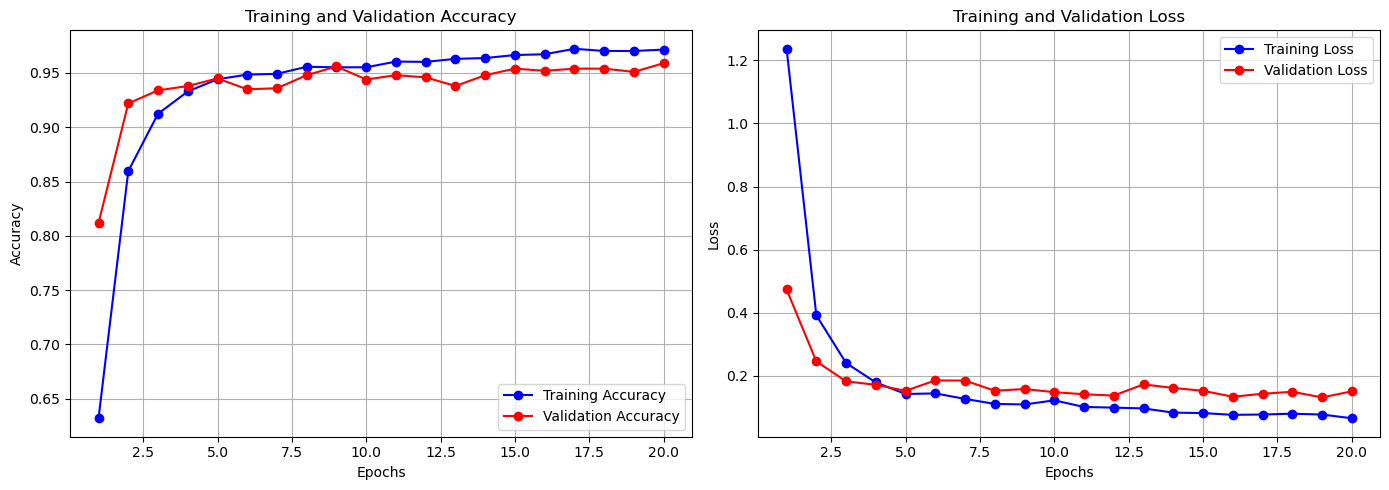

In [12]:
import matplotlib.pyplot as plt

# Assuming 'history' is the History object returned by model.fit()
def plot_training_history(history):
    # Retrieve metrics from history
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    epochs = range(1, len(acc) + 1)

    # Create subplots
    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)


In [13]:
# Giả sử mô hình đã được huấn luyện xong
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


32/32 [==============================] - 1s 31ms/step - loss: 0.1512 - accuracy: 0.9590
Test Loss: 0.15119369328022003
Test Accuracy: 0.9589589834213257


### Prediction

In [14]:
model = tf.keras.models.load_model('cnn_model.h5')
model.predict()


TypeError: Model.predict() missing 1 required positional argument: 'x'